In [1]:
import numpy as np 
import pandas as pd
import os
import torchvision
import time
import datetime

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
#from torch import device
import torch.nn as nn
import cv2
#from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid

from torchvision import models
from collections import namedtuple

import matplotlib.pyplot as plt
from IPython.display import Image

from glob import glob
from PIL import Image
import pydicom as dicom
import collections
import math
import random

import radiomics
from radiomics import featureextractor
from radiomics.featureextractor import RadiomicsFeatureExtractor # This module is used for interaction with pyradiomic
import logging
logging.getLogger('radiomics').setLevel(logging.CRITICAL + 1)  # this tool makes a whole TON of log noise

import SimpleITK as sitk
import six
from SimpleITK import GetImageFromArray

import tifffile as tiff
from tifffile import imsave

import natsort
import itertools
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
# Global settings

img_size =  (320, 320)
img_size_c  =  (120, 320)

NUM_EPOCHS = 120
BATCH_SIZE = 4

b1 = 0.5
b2 = 0.999

SEED = 35

In [4]:
PATH = 'D:/style transfer/code/MRI_stan/dataset/'
path_result = "D:/style transfer/access/training_result/"

path_new = "D:/style transfer/datasets/spider/train/"

In [5]:
# Parameters for Radiomics Features (RFs)

params = {}
params['binCount'] = 32
params['sigma'] = [1, 2, 3]
params['verbose'] = False

# Instantiate the extractor
extractor = RadiomicsFeatureExtractor(**params)

#texture_extractor = RadiomicsFeatureExtractor(verbose=False)
extractor.disableAllFeatures()
_text_feat = {ckey: [] for ckey in extractor.featureClassNames}
extractor.enableFeaturesByName(**_text_feat)

In [6]:
# Seeds

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create the directory of results
t = time.strftime("%H-%M-%S")

def get_date():
    now = time.localtime()
    s = "%04d-%02d-%02d" % (now.tm_year, now.tm_mon, now.tm_mday)
    return s

def make_folder(folder_name):
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)

today = get_date()
f = t+"_CycleGAN_seg_RF"
work_dir = path_result + today +"/"+f

make_folder(path_result+today)

os.chdir(path_result+today)
os.mkdir(f)

In [7]:
# Functions

def calc_radiomics(in_image_data):
    return extractor.execute(GetImageFromArray(in_image_data), GetImageFromArray((in_image_data>0).astype(np.uint8)))

lists = ['glcm_Idmn','glcm_Correlation','glcm_SumEntropy','glrlm_ShortRunEmphasis','glcm_DifferenceEntropy'] #list of pre-obtained RF
         
def get_radiomics(x):
    #img = ttoi(x)
    results = calc_radiomics(x)
    dat = pd.DataFrame([results])
    dat.columns = dat.columns.str.replace("original_","")
    dat = dat[lists]  
    dat_list = dat.values.tolist()
    #dat_tensor = torch.from_numpy(dat_list)
    return np.array(dat_list) #dat_tensor.to(device)

def normalize(img, n):  #0~1 float
    if img.max() == img.min():
        return np.zeros(img.shape)
    return ((img - img.min())/(img.max() - img.min()))*n
    
def read_tif(path, img_size, n):    
    img = tiff.imread(path)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)   
    img = normalize(img, n)
    return np.squeeze(np.stack([img[np.newaxis,:,:]])) 

def read(path, img_size, n):    
    dcm = dicom.dcmread(path)
    img = dcm.pixel_array      
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
    img = normalize(img, n)
    return np.squeeze(np.stack([img[np.newaxis,:,:]]))   

def read_new(img, img_size, n):    
    img = np.flip(img,0)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
    img = normalize(img, n)
    return img 

def img_crop(img, img_size, img_size_c):
    c = int(img_size[1]/2)
    crop_img = img[0:img_size[0],c-img_size_c[0]//2:c+img_size_c[0]//2]
    crop_img = cv2.resize(crop_img, img_size_c, interpolation=cv2.INTER_AREA)
    #crop_img = np.array(crop_img).clip(0,255.)
    crop_img = normalize(crop_img, 255.)
    return crop_img

In [8]:
# Import datasets (target (standard) and source (non-standard))

stan = pd.read_excel(PATH+'/train/standard_T1.xlsx', usecols = ['Path']) #3909

nstan1 = pd.read_excel(PATH+'/train/OSF_T1_train.xlsx') 
nstan2 = pd.read_excel(PATH+'/train/nonstan_T1_train.xlsx', usecols = ['Path']) 
nonstan = pd.concat([nstan1, nstan2], axis=0).reset_index(drop=True) #5645

nonstan = nonstan.drop('Unnamed: 0', axis=1) #5645

folders = os.listdir(path_new+"/images/")
folders = natsort.natsorted(folders)

image_new = [] #1761
for i in range(len(folders)):
    img_list = natsort.natsorted(glob(path_new+"/images/"+folders[i]+'/*.tif'))
    for j in range(len(img_list)):
        image_new.append(img_list[j])

df_new = pd.DataFrame(data= {'Path': image_new}) #1798

nstan = pd.concat([nonstan, df_new], axis=0).reset_index(drop=True) #7443
non_stan = nstan.iloc[np.random.permutation(nstan.index)].reset_index(drop=True)

files_xls = glob(PATH+'test/*xlsx')
df = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel(f, usecols = ['Path'])
    df = pd.concat([df,data])

tests1 = df.iloc[np.random.permutation(df.index)].reset_index(drop=True) #1455

In [9]:
# Import test dataset

path_test = "D:/style transfer/datasets/spider/test/"
folders1 = os.listdir(path_test+"/images/")
folders1 = natsort.natsorted(folders1)

image_ms = [] 
for i in range(len(folders1)):
    img_list = natsort.natsorted(glob(path_test+"/images/"+folders1[i]+'/*.tif'))
    for j in range(len(img_list)):
        image_ms.append(img_list[j])

df_ms = pd.DataFrame(data= {'Path': image_ms}) #397

test = pd.concat([tests1, df_ms], axis=0).reset_index(drop=True) #1852
tests = test.iloc[np.random.permutation(test.index)].reset_index(drop=True)

In [10]:
# Load the datasets (target and source)

class ImageDataset(Dataset):
    def __init__(self, nonstan_df, stan_df):
        super().__init__()
        self.stan_df = stan_df['Path']
        self.nonstan_df = nonstan_df['Path']  
        self.transforms = transforms.Compose([transforms.ToTensor()])       
        self.length_dataset = len(self.stan_df)
        #self.length_dataset = int(len(self.df)*0.5)
            
    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):        
        in_dc = self.nonstan_df[idx]
        tar_dc = self.stan_df[idx]     
        
        if in_dc.split('.')[-1] == 'tif':
            input_img = self._read_tif(in_dc, img_size, 255.) 
        else: input_img = self._read(in_dc, img_size, 255.)
        
        target_img = self._read(tar_dc, img_size, 255.)   
        
        input_img = Image.fromarray(input_img)
        target_img = Image.fromarray(target_img)
        
        input_img = self.transforms(input_img)
        target_img = self.transforms(target_img) 
        return { "inputs": input_img, "targets": target_img}
    
    def _read(self, path, img_size, n):    
        dcm = dicom.dcmread(path)
        #dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        #dcm.PixelRepresentation = 0
        img = dcm.pixel_array
        img = self._normalize(img, n)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
        return np.squeeze(np.stack([img[np.newaxis,:,:]]))     
    
    def _read_tif(self, path, img_size, n):    
        img = tiff.imread(path)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)   
        img = self._normalize(img, n)
        return np.squeeze(np.stack([img[np.newaxis,:,:]])) 

    def _normalize(self, img, n):  #0~1 float
        if img.max() == img.min():
            return np.zeros(img.shape)
        return ((img - img.min())/(img.max() - img.min()))*n

data_set = ImageDataset(non_stan, stan) #############
data_loader = torch.utils.data.DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

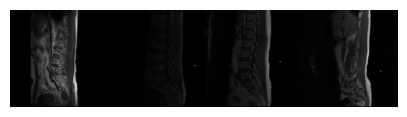

In [11]:
# Display the loaded source images (one batch) to check

dataiter = iter(data_loader)
images = next(dataiter)
grid = make_grid(images['inputs']/255., nrow=4).permute(1, 2, 0).detach().numpy()
#grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(5, 3))
plt.imshow(grid)
plt.axis('off')
plt.show()

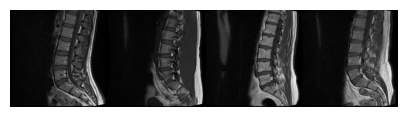

In [12]:
# Display the loaded target images (one batch) to check

grid = make_grid(images['targets']/255., nrow=4).permute(1, 2, 0).detach().numpy()
#grid_original = reverse_normalize(grid_normalized)
fig = plt.figure(figsize=(5, 3))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [11]:
# Load the test dataset

class TestDataset(Dataset):
    def __init__(self, tests):
        super().__init__()
        self.tests = tests['Path']        
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])       
        self.length_dataset = len(self.tests)
        #self.length_dataset = int(len(self.df)*0.5)
            
    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):        
        test_dc = self.tests[idx]    
        if test_dc.split('.')[-1] == 'tif':
            test_img = self._read_tif(test_dc, img_size, 255.)     
        else: test_img = self._read(test_dc, img_size, 255.) 
        test_img = Image.fromarray(test_img)
        test_img = self.transforms(test_img)        
        return test_img
    
    def _read(self, path, img_size, n):    
        dcm = dicom.dcmread(path)
        #dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        #dcm.PixelRepresentation = 0
        img = dcm.pixel_array      
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
        img = self._normalize(img, n)
        return np.squeeze(np.stack([img[np.newaxis,:,:]]))     
    
    def _read_tif(self, path, img_size, n):    
        img = tiff.imread(path)     
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)     
        img = self._normalize(img, n) 
        return np.squeeze(np.stack([img[np.newaxis,:,:]])) 

    def _normalize(self, img, n):  #0~1 float
        if img.max() == img.min():
            return np.zeros(img.shape)
        return ((img - img.min())/(img.max() - img.min()))*n
        
test_set = TestDataset(tests)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

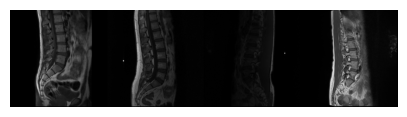

In [14]:
dataiter = iter(test_loader)
images = next(dataiter)
grid = make_grid(images/255., nrow=4).permute(1, 2, 0).detach().numpy()
fig = plt.figure(figsize=(5, 3))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [12]:
# Generator network

class TransformerNetwork(nn.Module):
    """
    reference: https://arxiv.org/abs/1603.08155 
    exact architecture: https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
    """
    def __init__(self):
        super(TransformerNetwork, self).__init__()
        self.ConvBlock = nn.Sequential(
            ConvLayer(1, 32, 9, 1),
            nn.ReLU(),
            ConvLayer(32, 64, 3, 2),
            nn.ReLU(),
            ConvLayer(64, 128, 3, 2),
            nn.ReLU())
        self.ResidualBlock = nn.Sequential(
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3))
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 1, 9, 1, norm="None"))

    def forward(self, x):
        x = self.ConvBlock(x)
        x = self.ResidualBlock(x)
        out = self.DeconvBlock(x)
        return out

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm="instance"):
        super(ConvLayer, self).__init__()
        # Padding Layers
        padding_size = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding_size)

        # Convolution Layer
        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv_layer(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

class ResidualLayer(nn.Module):
    """
    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385
    """
    def __init__(self, channels=128, kernel_size=3):
        super(ResidualLayer, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size, stride=1)

    def forward(self, x):
        identity = x                     # preserve residual
        out = self.relu(self.conv1(x))   # 1st conv layer + activation
        out = self.conv2(out)            # 2nd conv layer
        out = out + identity             # add residual
        return out

class DeconvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding, norm="instance"):
        super(DeconvLayer, self).__init__()

        # Transposed Convolution 
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.conv_transpose(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

In [13]:
# Discriminator network

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()

        in_channels = 1  ###############
        height = img_size[0]
        width = img_size[1]
        # Calculate output shape of image discriminator (PatchGAN) 34X34 PATCH
        self.output_shape = (in_channels, 78, 78)
       
        def discriminator_block(in_filters, out_filters, first_block=False, last_block=False):
            layers = []
            if last_block:
                layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=1, padding=1))
            else:
                layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1))
            if not first_block:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
           
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0), last_block=(i == 2)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, in_channels, kernel_size=4, stride=1, padding=1))
        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [14]:
## Functions used dring training

def convert(img, img_size, x):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA) 
    return np.array(img/x).clip(0,1)    
    
def show(img1, img2, img3, img4, img5): 
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(15,8)) ###########
    ax1.imshow(np.array(img1).clip(0,255), 'gray')
    ax2.imshow(np.array(img2).clip(0,255), 'gray')  
    ax3.imshow(np.array(img2).clip(0,255), 'gray')
    ax3.imshow(np.ma.masked_where(img4 == False, img4), cmap='autumn', alpha=0.3)    
    ax4.imshow(np.array(img3).clip(0,1), 'gray')  
    ax5.imshow(np.array(img5).clip(0,1), 'gray')
    plt.show()
    
# Tensor to Image
def ttoi(tensor):
    # Remove the batch_size dimension
    #tensor = tensor.squeeze()
    img = tensor.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

In [15]:
os.chdir(work_dir)
os.mkdir("model")

#path_g_S2N = "/model/g_S2N/"
path_g_N2S = "/model/g_N2S/"

#make_folder(work_dir+path_g_S2N)
make_folder(work_dir+path_g_N2S)

In [16]:
# Load the U-nets (S_x, S_y) x: source, y: target

path_result = "D:/style transfer/access/training_result/"

resnet_y = smp.Unet(encoder_name='resnet34', encoder_weights="imagenet", activation='sigmoid') # U-net pre-trained on the target images
resnet_x =  smp.Unet(encoder_name='resnet34', encoder_weights="imagenet",  activation='sigmoid') 
resnet_y.load_state_dict(torch.load(path_result+"2023-08-28/15-14-43_U34_MRI_320/model/unet/checkpoint_166_25.pth"))

<All keys matched successfully>

In [17]:
# Generators and Discriminators
G_N2S = TransformerNetwork().to(device)
G_S2N = TransformerNetwork().to(device)
D_S = Discriminator(img_size).to(device)
D_N = Discriminator(img_size).to(device)

# Pre-trained U-Net on standard (target) images
unet_S = resnet_y.to(device)

# U_Net for non-standard (source) images
unet_N = resnet_x.to(device)

#feature_extractor = VGG16('D:/style transfer/vgg16-00b39a1b.pth').to(device)

for param in unet_S.parameters():
    param.requires_grad = False

for param in unet_N.parameters():
    param.requires_grad = True

# Loss functions
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_cycle = torch.nn.L1Loss().to(device)
criterion_ID = torch.nn.L1Loss().to(device) # MAE
criterion_RF = torch.nn.L1Loss().to(device)
criterion_DICE = smp.utils.losses.DiceLoss().to(device)

# Hyper parameters
######################################
sample_interval = 200
lr = 2*1e-5
GAN_WEIGHT = 10.
CYC_WEIGHT = 10.
ID_WEIGHT = 10.
RF_WEIGHT = 10
D_WEIGHT = 20. 
DICES_WEIGHT = 20.
DICEN_WEIGHT = 10.
# CONTENT_WEIGHT = 0.02
# STYLE_WEIGHT = 10.
# style_weight = [1/10**n for n in [5,5,4,3]]
######################################

optimizer_G = torch.optim.Adam(itertools.chain(G_N2S.parameters(), G_S2N.parameters()), lr=lr, betas=(b1, b2))
optimizer_D_S = torch.optim.Adam(D_S.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_N = torch.optim.Adam(D_N.parameters(), lr=lr, betas=(b1, b2))
optimizer_U = torch.optim.Adam(unet_N.parameters(), lr=0.001, betas=(b1, b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Load the pre-obtained Radiomic Feature (RF) values
standard_rf = PATH+'/standard_RF5.npy'
stan_RF = np.load(standard_rf, allow_pickle=True)

In [ ]:
loss_hist = {'G_loss':[], 'DiceS_loss':[] , 'DiceN_loss':[], 'ID_loss':[], 'Cycle_loss':[], 'RF_loss':[]}#, 'Style_loss':[], 'Cont_loss':[]}

prev_time = time.time()
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    for i, imgs in enumerate(data_loader):
        # Configure model input
        inputs = Variable(imgs["inputs"].type(Tensor)) 
        targets = Variable(imgs["targets"].type(Tensor)) 

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((inputs.size(0), *D_S.output_shape))), requires_grad=False) 
        fake = Variable(Tensor(np.zeros((inputs.size(0), *D_S.output_shape))), requires_grad=False) 
         
        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()
        optimizer_U.zero_grad()
        
        fake_S = G_N2S(inputs)
        fake_N = G_S2N(targets)
        
        S2S = G_N2S(targets)
        N2N = G_S2N(inputs)
        
        # Identity mapping loss
        loss_id_S = criterion_ID(S2S, targets)
        loss_id_N = criterion_ID(N2N, inputs)

        loss_id = ID_WEIGHT*(loss_id_N + loss_id_S) ###
        
        # GAN loss
        loss_GAN_N2S = criterion_GAN(D_S(fake_S), valid)
        loss_GAN_S2N = criterion_GAN(D_N(fake_N), valid)
        
        loss_GAN = GAN_WEIGHT*(loss_GAN_N2S + loss_GAN_S2N)  ###
        
        # Cycle consistency loss
        recov_S = G_N2S(fake_N)
        loss_cycle_S = criterion_cycle(recov_S, targets)
        recov_N = G_S2N(fake_S)
        loss_cycle_N = criterion_cycle(recov_N, inputs)
        loss_cycle = CYC_WEIGHT*(loss_cycle_S + loss_cycle_N)
        
        # RF loss
        sample_tensor = fake_S[0].clone().detach()
        RF_img = ttoi(sample_tensor)
        #RF_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
        RF_img = np.array(RF_img).clip(0,255.)
        rf_img = img_crop(RF_img[:,:,0], img_size, img_size_c)  
        gen_RF = get_radiomics(rf_img)
        
        gen_RF_t = torch.from_numpy(gen_RF).clone().detach().requires_grad_(True)
        stan_RF_t = torch.from_numpy(stan_RF[0,:,:]).clone().detach().requires_grad_(True)
        RF_loss = RF_WEIGHT*criterion_RF(gen_RF_t, stan_RF_t) ###
        
        #unet_S
        stan_seg  = unet_S(targets.repeat(1, 3, 1, 1)) # Ground truth
        fake_S_seg  = unet_S(fake_S.repeat(1, 3, 1, 1)) # Ground truth
        
        recov_S_seg  = unet_S(recov_S.repeat(1, 3, 1, 1)) # c
        dice_diff_S1 = DICES_WEIGHT*criterion_DICE(recov_S_seg, stan_seg)
        
        S2S_seg = unet_S(S2S.repeat(1, 3, 1, 1)) # id
        dice_diff_S2 = DICES_WEIGHT*criterion_DICE(S2S_seg, stan_seg) 
        
        dice_diff_S =  dice_diff_S1 + dice_diff_S2 
        
        #unet_N             
        inputs_seg  = unet_N(inputs.repeat(1, 3, 1, 1))
        dice_diff_Nn1 = DICEN_WEIGHT*criterion_DICE(inputs_seg, fake_S_seg)

        N2N_seg = unet_N(N2N.repeat(1, 3, 1, 1)) # id
        dice_diff_Nn2 = DICEN_WEIGHT*criterion_DICE(N2N_seg, fake_S_seg)

        recov_N_seg  = unet_N(recov_N.repeat(1, 3, 1, 1)) # c
        dice_diff_Nn3 = DICEN_WEIGHT*criterion_DICE(recov_N_seg, fake_S_seg)
            
         fake_N_seg  = unet_N(fake_N.repeat(1, 3, 1, 1)) # h
         dice_diff_Ns = DICEN_WEIGHT*criterion_DICE(fake_N_seg, stan_seg)
        
        dice_diff_N = dice_diff_Nn2 + dice_diff_Nn1 + dice_diff_Nn3 +  dice_diff_Ns
        
        # Total loss
        loss_G = loss_id  + loss_cycle + loss_GAN + dice_diff_S  + dice_diff_N + RF_loss
        
        dice_diff_N.backward(retain_graph=True)
        optimizer_U.step()

        loss_G.backward()
        optimizer_G.step()              
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D_S.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(D_S(targets), valid)
        loss_fake = criterion_GAN(D_S(fake_S.detach()), fake)

        # Total loss
        loss_D_S = (loss_real + loss_fake)*D_WEIGHT

        loss_D_S.backward()
        optimizer_D_S.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D_N.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(D_N(inputs), valid)
        loss_fake = criterion_GAN(D_N(fake_N.detach()), fake)

        # Total loss
        loss_D_N = (loss_real + loss_fake)*D_WEIGHT

        loss_D_N.backward()
        optimizer_D_N.step()
        
        loss_D = loss_D_S + loss_D_N
        
        # --------------
        #  Log Progress
        # --------------

        loss_hist['G_loss'].append(loss_G.item())
        loss_hist['DiceS_loss'].append(dice_diff_S.item())
        loss_hist['DiceN_loss'].append(dice_diff_N.item())
        loss_hist['ID_loss'].append(loss_id.item())
        loss_hist['Cycle_loss'].append(loss_cycle.item())
        loss_hist['RF_loss'].append(RF_loss.item())
        
        # Determine approximate time left
        batches_done = epoch * len(data_loader) + i
        batches_left = NUM_EPOCHS * len(data_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
               
        if batches_done % sample_interval == 0:

            print("[Epoch %d/%d] [Batch %d/%d] ETA: %s" % (epoch+1, NUM_EPOCHS, i, len(data_loader), time_left))
            print("[G loss: %.3f] [DiceS loss: %.3f] [DiceN loss: %.3f] [ID_loss: %.3f] [Cycle_loss: %.3f] [RF_loss: %.3f]"
                  % (loss_G.item(), dice_diff_S.item(), dice_diff_N.item(), loss_id.item(), loss_cycle.item(), RF_loss.item()))
          
            G_N2S.eval()
            G_S2N.eval()
            unet_N.eval()
            #unet_S.eval()
              
            
            # Display the test results 
            dataiter = iter(test_loader)
            tests = next(dataiter)
            tests = Variable(tests.type(Tensor)) # bs,3,80,30
           
            #images = img.expand(-1, 3, -1, -1) 
            
            test_img = tests[0].clone().detach()
            test_img = ttoi(test_img)  
            gen_test = G_N2S(tests)#.detach().cpu() 
            
            sample_tensor = gen_test[0].clone().detach()
            sample_image = ttoi(sample_tensor)
            
            raw_pred = unet_S(tests.repeat(1, 3, 1, 1).to(device))
            raw_p = raw_pred[0].detach().cpu().numpy().transpose(1, 2, 0)
            raw_p[np.nonzero(raw_p < 0.4)] = 0.0
            raw_p[np.nonzero(raw_p >= 0.4)] = 1.
            
            gen_pred  = unet_S(gen_test.repeat(1, 3, 1, 1))
            gen_p = gen_pred[0].detach().cpu().numpy().transpose(1, 2, 0)
            gen_p[np.nonzero(gen_p < 0.4)] = 0.0
            gen_p[np.nonzero(gen_p >= 0.4)] = 1.
            
            #recov_S_s = ttoi(recov_S[0].clone().detach())
            #gen_s = fake_N_seg[0].detach().cpu().numpy().transpose(1, 2, 0)
            #stan_s = stan_seg[0].detach().cpu().numpy().transpose(1, 2, 0)
           
            show(test_img, sample_image, gen_p, gen_p, raw_p)
        
            # Save Model
            checkpoint_path_g_N2S = work_dir+path_g_N2S + "checkpoint_g_N2S_" + str(epoch+1)+'_'+str(i) + ".pth"
            torch.save(G_N2S.state_dict(), checkpoint_path_g_N2S)

            G_N2S.train()
            G_S2N.train()
            unet_N.train()
    del inputs
    del targets
    torch.cuda.empty_cache()

stop_time = time.time()
print("Training Time: {} seconds".format(stop_time-start_time))